<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [10]:

import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

import pylab
#matplotlib inline

from scipy.stats import bernoulli, beta   

plt.rcParams['figure.figsize']=(15, 8)

In [6]:
# datos
Cookiecats= pd.read_csv('data/cookie_cats.csv')

Cookiecats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [71]:
# transformacion
Cookiecats['retention_1'].value_counts()


retention_1
False    50036
True     40153
Name: count, dtype: int64

In [72]:
Cookiecats['retention_7'].value_counts()

retention_7
False    73408
True     16781
Name: count, dtype: int64

In [73]:
Conv= pd.crosstab(Cookiecats['version']== 'gate_30', Cookiecats['version']== 'gate_40')
Conv

print (Conv)

version  False  True 
version              
False        0  45489
True     44700      0


In [74]:
Conv1= pd.crosstab(Cookiecats['version'], Cookiecats['retention_1'])
Conv1

print (Conv1, 
       'Conversion is ', 20119-20034)

retention_1  False  True 
version                  
gate_30      24666  20034
gate_40      25370  20119 Conversion is  85


In [75]:
Conv7= pd.crosstab(Cookiecats['version'], Cookiecats['retention_7'])
Conv7

print (Conv7, 
       'Conversion is ', 8279-8502)

retention_7  False  True 
version                  
gate_30      36198   8502
gate_40      37210   8279 Conversion is  -223


In [76]:
print(20034/44700, 20119/45489, (0.4481879194630872-0.44228274967574577))

0.4481879194630872 0.44228274967574577 0.005905169787341458


In [77]:
efecto=sms.proportion_effectsize(0.45, 0.44)

efecto

n_requerido = sms.NormalIndPower().solve_power(efecto,     
                                               power=0.8,
                                               alpha=0.05
                                              )

n_requerido


38768.09024379976

In [78]:
Cat_30 = Cookiecats[Cookiecats['version']=='gate_30'].sample(n=int(n_requerido), random_state=22)

Cat_40 = Cookiecats[Cookiecats['version']=='gate_40'].sample(n=int(n_requerido), random_state=22)

ab_test=pd.concat([Cat_30, Cat_40], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [79]:
ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
77531,6516441,gate_40,4,False,False
77532,4168106,gate_40,6,True,False
77533,3785761,gate_40,9,True,False
77534,9750189,gate_40,191,True,False
77535,7359429,gate_40,164,True,False


In [80]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          77536 non-null  int64 
 1   version         77536 non-null  object
 2   sum_gamerounds  77536 non-null  int64 
 3   retention_1     77536 non-null  bool  
 4   retention_7     77536 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.9+ MB


In [84]:
ab_test.version.value_counts()

version
gate_30    38768
gate_40    38768
Name: count, dtype: int64

In [85]:
tasas_retencion = ab_test.groupby('version')['retention_1']    # agrupacion por grupo


std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_retencion = tasas_retencion.agg([np.mean, std, error_std])

tasas_retencion.columns = ['conversion_rate', 'std', 'sem']
tasas_retencion.style.format('{:.3f}')

,conversion_rate,std,sem
version,,,
gate_30,0.448,0.497,0.003
gate_40,0.444,0.497,0.003


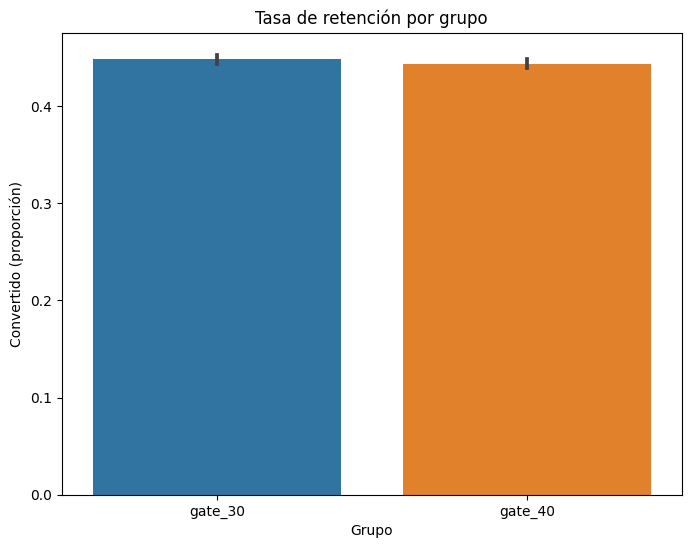

In [98]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])


plt.title('Tasa de retención por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [15]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [90]:

control_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']

In [112]:
sum(control_res)

7350

In [92]:
impresiones=[38768, 38768]  # count  , impresiones
    
conversiones=[control_res.sum(), trat_res.sum()]    # conversiones


z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [93]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.21
p-valor: 0.225
intervalo conf 95% para grupo control: [0.443, 0.453]
intervalo conf 95% para grupo tratamiento: [0.439, 0.449]


In [16]:
from scipy.stats import norm

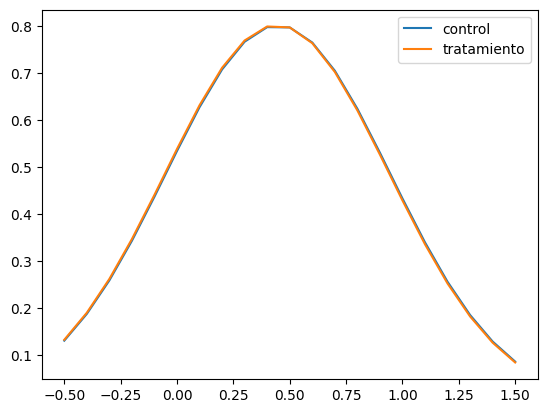

In [97]:
x=[i*.1 for i in range(-5, 16)]  

# norm.pdf(x, media, std)

control=[norm.pdf(x, tasas_retencion.iloc[0][0], tasas_retencion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_retencion.iloc[1][0], tasas_retencion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [3]:
# muestreo


In [4]:
# testeo para retention_1


In [7]:
# testeo para retention_7 #No Bayes. Bayes más abajo.
Conv7= pd.crosstab(Cookiecats['version'], Cookiecats['retention_7'])
Conv7

print (Conv7, 
       'Conversion is ', 8279-8502)

print(8502/44700, 8279/45489, (0.19020134228187918-0.18200004396667327))



retention_7  False  True 
version                  
gate_30      36198   8502
gate_40      37210   8279 Conversion is  -223
0.19020134228187918 0.18200004396667327 0.008201298315205913


In [9]:
efecto7=sms.proportion_effectsize(0.19, 0.18)

efecto7

n_requerido7 = sms.NormalIndPower().solve_power(efecto7,     
                                               power=0.8,
                                               alpha=0.05
                                              )

n_requerido7

23664.347301915222

In [10]:
Cat_30_7 = Cookiecats[Cookiecats['version']=='gate_30'].sample(n=int(n_requerido7), random_state=22)

Cat_40_7 = Cookiecats[Cookiecats['version']=='gate_40'].sample(n=int(n_requerido7), random_state=22)

ab_test7=pd.concat([Cat_30_7, Cat_40_7], axis=0)

ab_test7.reset_index(drop=True, inplace=True)

ab_test7.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [11]:
ab_test7.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
47323,9528280,gate_40,8,True,False
47324,3129623,gate_40,64,True,False
47325,3163418,gate_40,3,False,False
47326,5971780,gate_40,95,True,False
47327,602779,gate_40,12,False,False


In [12]:
ab_test7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47328 entries, 0 to 47327
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          47328 non-null  int64 
 1   version         47328 non-null  object
 2   sum_gamerounds  47328 non-null  int64 
 3   retention_1     47328 non-null  bool  
 4   retention_7     47328 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.2+ MB


In [18]:
tasas_retencion7 = ab_test7.groupby('version')['retention_1']    # agrupacion por grupo


std7 = lambda x: np.std(x, ddof=0)              # std
error_std7= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_retencion7 = tasas_retencion7.agg([np.mean, std7, error_std7])

tasas_retencion7.columns = ['conversion_rate', 'std', 'sem']
tasas_retencion7.style.format('{:.3f}')

,conversion_rate,std,sem
version,,,
gate_30,0.449,0.497,0.003
gate_40,0.440,0.496,0.003


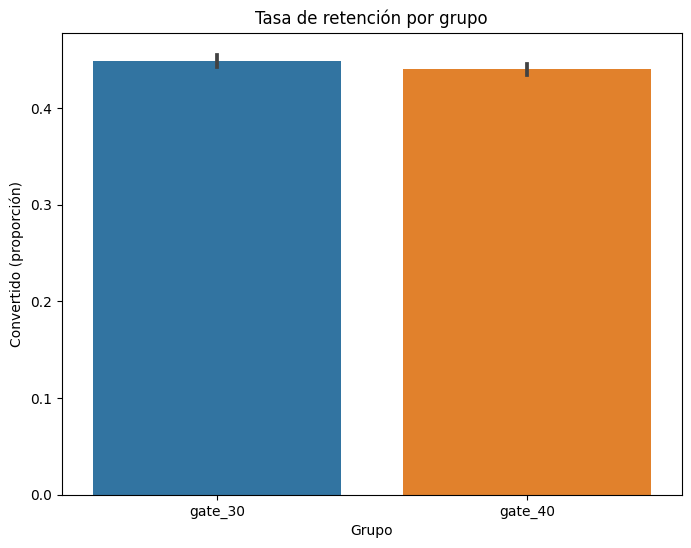

In [19]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test7['version'], 
            y=ab_test7['retention_1'])


plt.title('Tasa de retención por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [22]:
control_res7=ab_test7[ab_test7.version=='gate_30']['retention_7']

trat_res7=ab_test7[ab_test7.version=='gate_40']['retention_7']

In [23]:
sum(control_res7)

4465

In [24]:
impresiones7=[38768, 38768]  # count  , impresiones
    
conversiones7=[control_res7.sum(), trat_res7.sum()]    # conversiones


z_score7, p_value7 = proportions_ztest(conversiones7, nobs=impresiones7)

(control_a7, trata_a7), (control_b7, trata_b7) = proportion_confint(conversiones7, 
                                                                nobs=impresiones7,
                                                                alpha=0.05)

In [25]:
print(f'z-score: {z_score7:.2f}')

print(f'p-valor: {p_value7:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a7:.3f}, {control_b7:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a7:.3f}, {trata_b7:.3f}]')

z-score: 2.85
p-valor: 0.004
intervalo conf 95% para grupo control: [0.112, 0.118]
intervalo conf 95% para grupo tratamiento: [0.106, 0.112]


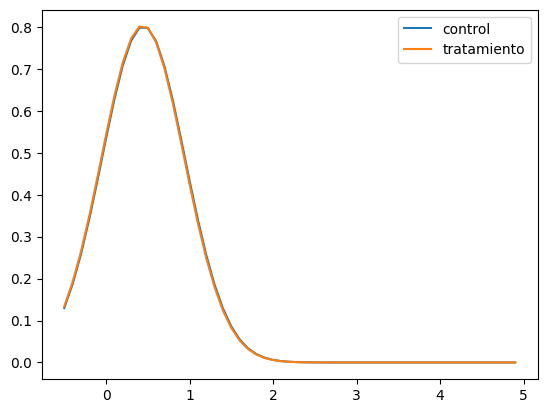

In [29]:
x=[i*.1 for i in range(-5, 50)]  

# norm.pdf(x, media, std)

control7=[norm.pdf(x, tasas_retencion7.iloc[0][0], tasas_retencion7.iloc[0][1]) for x in x7] 

tratamiento7=[norm.pdf(x, tasas_retencion7.iloc[1][0], tasas_retencion7.iloc[1][1]) for x in x7] 

plt.plot(x, control7)
plt.plot(x, tratamiento7)
plt.legend(['control', 'tratamiento']);

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.


#En el caso del día 1, tras un analisis frecuentista, el p-valor de 0.025 nos indica que no podemos rechazar la Hipótesis original, es decir, que no podemos decir que las medias sean distintas.

#Los intervalos de confianza de la población control y de la población test están practicamente solapados, y la gráfica nos muestra ambas curvas como prácticamente indistinguibles.

In [2]:
# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = 44700, 8502    # entrar, comprar

imps_test, convs_test = 45489, 8279


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [7]:
# a prioris

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [8]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [29]:
x=np.linspace(0, 0.2, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

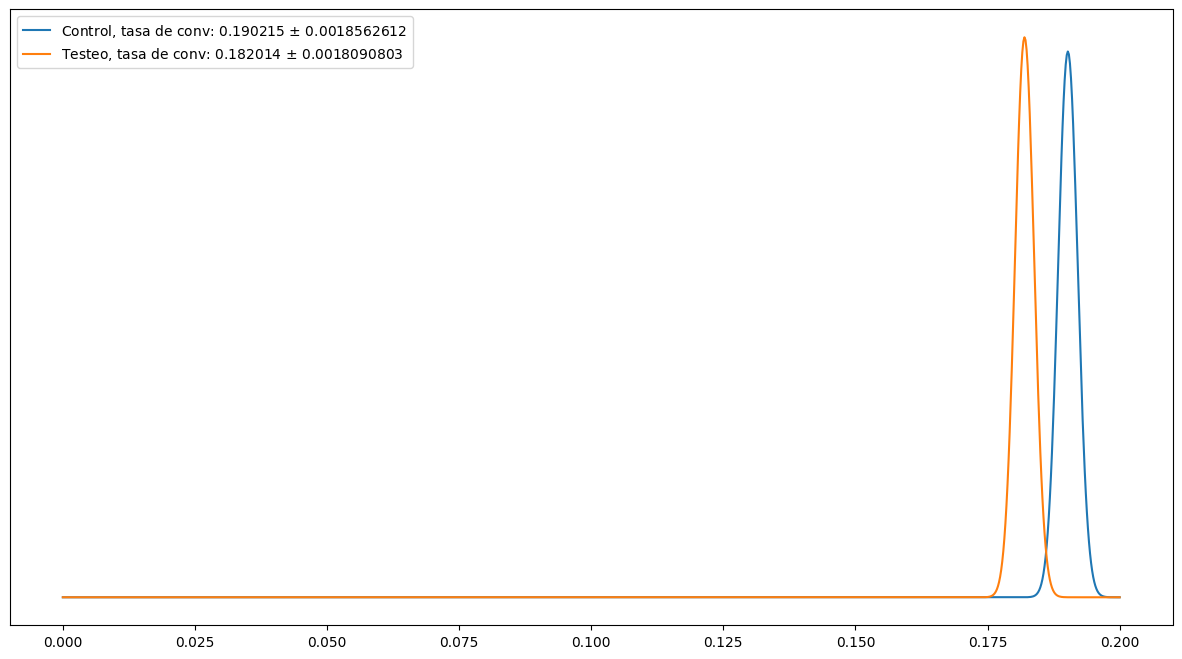

In [30]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [31]:
salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.04311526114658881

In [32]:
prob = 1 - beta_test.cdf(0.0024)

prob

1.0

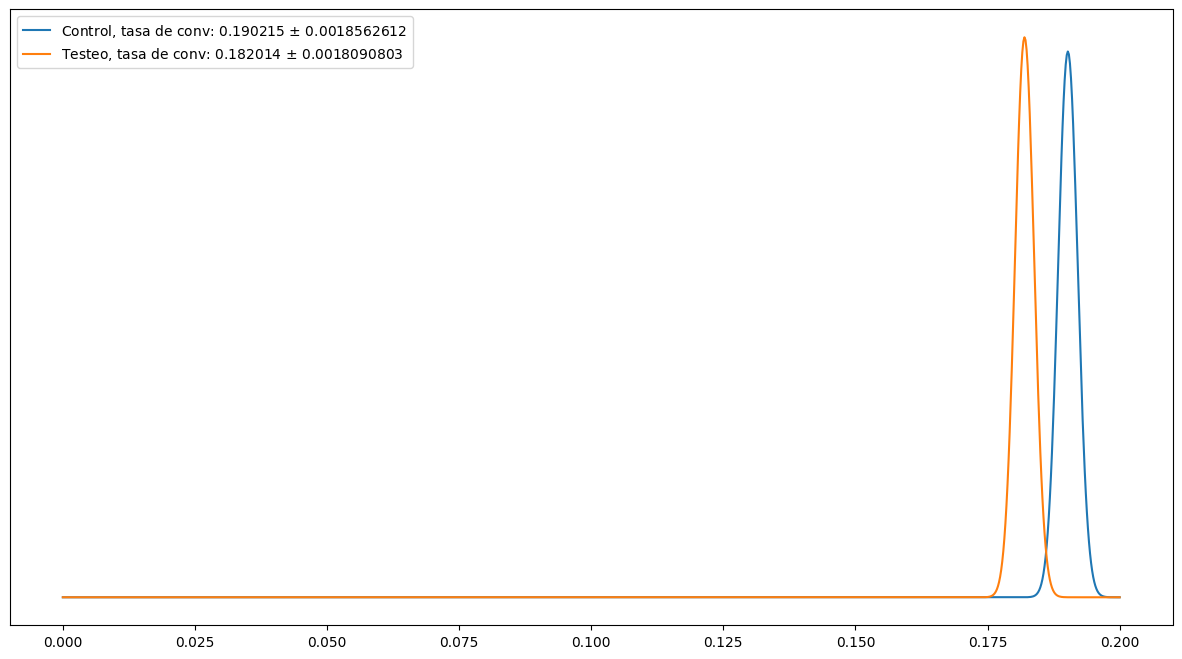

In [33]:
plot([beta_control, beta_test], ['Control', 'Testeo'])